In this Notebook we will explore the possibilities to finding gender bias in dutch static word embeddings. Because a lot of work is already done on occupational words we will focus on gender bias of dutch words describing charactaristics. These words should be gender-neutral. Our hypothesis is that some words contain some stereotypes. For example we expect a word like 'caring' to be biased towards women, and a word like 'ambitious' to be biased more towards men.

The notebook will have the following elements
1. Load the collection of static dutch word embeddings
2. Find the gender-subspace
3. Selection of gender-neutral characteristic words & Visualise together with she-he subspace
4. Visualisation of the she-he axis, the characteristic words, and the projection of the characteristic words onto the she-he axis
5. Debiasing the charateristic words
6. Visualise the corrected characteristic words
7. We should generate something to show that the other characteristics of the word are still intact. (maybe use the most_similar function) or find analogy pairs maybe ? using the function from https://towardsdatascience.com/man-is-to-computer-programmer-as-woman-is-to-homemaker-e57b07cbde96

# Imports


In [1]:
# When you are working in Colab, make sure you connect your Google Drive to Colab
# and upload the word embedding file to your google Drive

from google.colab import drive
drive.mount('/content/drive')

# Make sure you save your embeddings to your google drive
# and save the location in the path_to_embeddings
path_to_embeddings = "/content/drive/MyDrive/wikipedia-160.txt"
# path_to_embeddings = "/content/drive/MyDrive/wikipedia-small.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import tensorflow as tf
import datetime, os
import tensorflow_datasets as tfds
from tensorboard.plugins import projector
import csv
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

import sys
sys.path.append("/content/drive/MyDrive/debiaswe")  # Replace "/content/repository" with the path where the repository is cloned

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

## Load the collection of static dutch word embeddings
We will use the collection of static dutch word embeddings by Tulken 2016.

TODO basic info on this dataset:
Dataset source https://github.com/clips/dutchembeddings. Make sure you save the dataset locally on the drive in the correct folder. Define the path_to_embeddings in the cell above


In [3]:
%%time
E = WordEmbedding(path_to_embeddings)

*** Reading data from /content/drive/MyDrive/wikipedia-160.txt
(1043344, 160)
1043344 words of dimension 160 : \, \bar, \break, \clef, ..., ﺒ, －, ￡, ￥
CPU times: user 2min 9s, sys: 4.5 s, total: 2min 14s
Wall time: 2min 19s


Before downloading the full embedding we will test with the wikipedia dataset. We will use the first and last 5000 entries of this dataset


In [4]:
# # Load the embeddings model with gensim
# from gensim.models import KeyedVectors

# # Just some example code to see if loading the embeddings worked
# # model = KeyedVectors.load_word2vec_format(path_to_embeddings)
# katvec = E.model['meisje']
# E.model.most_similar('meisje')

## Define the gender specific words and the character words
The gender specific words are from pascals paper
The personality traits are from the paper that Vera found and translated from english to dutch

In [68]:
gender_specific_man = ['oom', 'broers', 'grootvader', 'bruidegom', 'man', 'prins',
       'vriend', 'presentator', 'jongen', 'vader', 'opa', 'hij',
       'koning', 'zoon', 'kapper', 'broer', 'papa', 'kleinzoon',
       'zijn', 'neef', 'leraar', 'directeur', 'atleet']

gender_specific_woman = ['tante', 'zussen', 'grootmoeder', 'bruid', 'vrouw', 'prinses',
         'vriendin', 'presentatrice', 'meisje', 'moeder', 'oma', 'zij',
         'koningin', 'dochter', 'kapster', 'zus', 'mama', 'kleindochter',
         'haar', 'nicht', 'lerares', 'directrice', 'atlete']

# These personality traits are extracted from figure 2 from the paper: Gender Stereotypes in Natural Language: Word Embeddings Show Robust Consistency Across Child and Adult Language Corpora of More Than 65 Million Words
# They were translated in google translate.
# personality_traits_man_en = ['strong', 'serious', 'frank', 'stable', 'independent', 'tough', 'responsible', 'upright', 'verbal', 'practical', 'defensive', 'cruel', 'direct', 'shallow', 'rigid', 'bold', 'original', 'proud', 'daring', 'stupid', 'creative', 'controlled', 'accurate', 'cooperative', 'honest', 'brave', 'rational', 'unfair', 'severe', 'generous', 'forward', 'deep', 'aggressive', 'noisy', 'reasonable', 'bossy', 'dull', 'artificial', 'intelligent']
# personality_traits_woman_en = ['assured', 'clever', 'affected', 'moral', 'respectable', 'peaceful', 'reserved', 'grumpy', 'formal', 'confident', 'critical', 'committed', 'able', 'polite', 'smart', 'bright', 'spiritual', 'cautious', 'meek', 'traditional', 'superficial', 'resigned', 'fair', 'strict', 'natural', 'brilliant', 'determined', 'dishonest', 'mischievous', 'capable', 'loyal', 'rude', 'artistic', 'greedy', 'active', 'dedicated', 'lonely', 'intellectual', 'cranky', 'sloppy', 'crude', 'impolite', 'just', 'sly', 'selfish', 'educated', 'helpful', 'sophisticated', 'careful', 'steady', 'sympathetic', 'understanding', 'silent', 'gloomy', 'stubborn', 'thoughtful', 'polished', 'talented', 'relaxed', 'clumsy', 'lively', 'harsh', 'organized', 'trusting', 'simple', 'sensitive', 'lazy', 'impatient', 'competitive', 'restless', 'complaining', 'efficient', 'satisfied', 'helpless', 'suspicious', 'neat', 'playful', 'hard', 'depressed', 'eager', 'complex', 'sarcastic', 'jolly', 'angry', 'jealous', 'messy', 'curious', 'enthousiastic', 'merry', 'fearful', 'cheerful', 'subtle', 'cold', 'bitter', 'demanding', 'touchy', 'casual', 'rash', 'ambitious', 'kind', 'consistent', 'charming', 'calm', 'sexy', 'intense', 'tender', 'soft', 'gracious', 'indifferent', 'social', 'precise', 'nervous', 'happy', 'alert', 'weak', 'tidy', 'anxious', 'warm', 'careless', 'mature', 'romantic', 'tense', 'friendly', 'patient', 'worried', 'feminine', 'shy', 'gentle', 'affectionate', 'pleasant', 'retiring']
# personality_traits_man = ['sterk', 'serieus', 'openhartig', 'stabiel', 'onafhankelijk', 'stoer', 'verantwoordelijk', 'integer', 'verbaal', 'praktisch', 'defensief', 'wreed', 'direct', 'oppervlakkig', 'star', 'dapper', 'origineel', 'trots', 'gewaagd', 'stom', 'creatief', 'beheerst', 'nauwkeurig', 'coöperatief', 'eerlijk', 'moedig', 'rationeel', 'oneerlijk', 'streng', 'royaal', 'vooruitstrevend', 'diepgaand', 'agressief', 'luidruchtig', 'redelijk', 'bazig', 'saai', 'kunstmatig', 'intelligent']
# personality_traits_woman = ['zelfverzekerd', 'slim', 'beïnvloedbaar', 'moreel', 'respectabel', 'vreedzaam', 'gereserveerd', 'chagrijnig', 'formeel', 'zelfverzekerd', 'kritisch', 'toegewijd', 'bekwaam', 'beleefd', 'slim', 'helder', 'spiritueel', 'voorzichtig', 'meegaand', 'traditioneel', 'oppervlakkig', 'resoluut', 'eerlijk', 'streng', 'natuurlijk', 'briljant', 'vastberaden', 'oneerlijk', 'ondeugend', 'capabel', 'loyaal', 'onbeschoft', 'artistiek', 'hebzuchtig', 'actief', 'toegewijd', 'eenzaam', 'intellectueel', 'chagrijnig', 'slordig', 'grof', 'onbeleefd', 'rechtvaardig', 'sluw', 'egoïstisch', 'geschoold']

personality_traits_man_en = ['strong', 'serious', 'frank', 'stable', 'independent', 'tough', 'responsible', 'upright', 'verbal', 'practical', 'defensive', 'cruel', 'direct', 'shallow', 'rigid', 'bold', 'original', 'proud', 'daring', 'stupid', 'creative', 'controlled', 'accurate', 'cooperative', 'honest', 'brave', 'rational', 'unfair', 'severe', 'generous', 'forward', 'deep', 'aggressive', 'noisy', 'reasonable', 'bossy', 'dull', 'artificial', 'intelligent']
personality_traits_woman_en = ['assured', 'clever', 'affected', 'moral', 'respectable', 'peaceful', 'reserved', 'grumpy', 'formal', 'confident', 'critical', 'committed', 'able', 'polite', 'smart', 'bright', 'spiritual', 'cautious', 'meek', 'traditional', 'superficial', 'resigned', 'fair', 'strict', 'natural', 'brilliant', 'determined', 'dishonest', 'mischievous', 'capable', 'loyal', 'rude', 'artistic', 'greedy', 'active', 'dedicated', 'lonely', 'intellectual', 'cranky', 'sloppy', 'crude', 'impolite', 'just', 'sly', 'selfish', 'educated', 'helpful', 'sophisticated', 'careful', 'steady', 'sympathetic', 'understanding', 'silent', 'gloomy', 'stubborn', 'thoughtful', 'polished', 'talented', 'relaxed', 'clumsy', 'lively', 'harsh', 'organized', 'trusting', 'simple', 'sensitive', 'lazy', 'impatient', 'competitive', 'restless', 'complaining', 'efficient', 'satisfied', 'helpless', 'suspicious', 'neat', 'playful', 'hard', 'depressed', 'eager', 'complex', 'sarcastic', 'jolly', 'angry', 'jealous', 'messy', 'curious', 'enthusiastic', 'merry', 'fearful', 'cheerful', 'subtle', 'cold', 'bitter', 'demanding', 'touchy', 'casual', 'rash', 'ambitious', 'kind', 'consistent', 'charming', 'calm', 'sexy', 'intense', 'tender', 'soft', 'gracious', 'indifferent', 'social', 'precise', 'nervous', 'happy', 'alert', 'weak', 'tidy', 'anxious', 'warm', 'careless', 'mature', 'romantic', 'tense', 'friendly', 'patient', 'worried', 'feminine', 'shy', 'gentle', 'affectionate', 'pleasant', 'retiring']

personality_traits_man = ['sterk', 'serieus', 'openhartig', 'stabiel', 'onafhankelijk', 'stoer', 'verantwoordelijk', 'integer', 'verbaal', 'praktisch', 'defensief', 'wreed', 'direct', 'oppervlakkig', 'star', 'dapper', 'origineel', 'trots', 'gewaagd', 'stom', 'creatief', 'beheerst', 'nauwkeurig', 'coöperatief', 'eerlijk', 'moedig', 'rationeel', 'oneerlijk', 'streng', 'royaal', 'vooruitstrevend', 'diepgaand', 'agressief', 'luidruchtig', 'redelijk', 'bazig', 'saai', 'kunstmatig', 'intelligent']
personality_traits_woman = ['zelfverzekerd', 'slim', 'beïnvloedbaar', 'moreel', 'respectabel', 'vreedzaam', 'gereserveerd', 'chagrijnig', 'formeel', 'zelfverzekerd', 'kritisch', 'toegewijd', 'bekwaam', 'beleefd', 'intelligent', 'helder', 'spiritueel', 'voorzichtig', 'nederig', 'traditioneel', 'oppervlakkig', 'berustend', 'eerlijk', 'streng', 'natuurlijk', 'briljant', 'vastberaden', 'oneerlijk', 'ondeugend', 'bekwaam', 'loyaal', 'onbeleefd', 'artistiek', 'hebzuchtig', 'actief', 'toegewijd', 'eenzaam', 'intellectueel', 'knorrig', 'slordig', 'grof', 'onbeleefd', 'rechtvaardig', 'sluw', 'egoïstisch', 'geschoold', 'behulpzaam', 'verfijnd', 'voorzichtig', 'stabiel', 'sympathiek', 'begrijpend', 'stil', 'somber', 'koppig', 'attent', 'gepolijst', 'getalenteerd', 'ontspannen', 'onhandig', 'levendig', 'hard', 'georganiseerd', 'vertrouwend', 'eenvoudig', 'gevoelig', 'lui', 'ongeduldig', 'competitief', 'rusteloos', 'klaaglijk', 'efficiënt', 'tevreden', 'hulpeloos', 'argwanend', 'netjes', 'speels', 'hard', 'depressief', 'gretig', 'complex', 'sarcastisch', 'vrolijk', 'boos', 'jaloers', 'rommelig', 'nieuwsgierig', 'enthousiast', 'vrolijk', 'angstig', 'vrolijk', 'subtiel', 'koud', 'bitter', 'veeleisend', 'prikkelbaar', 'informeel', 'overhaast', 'ambitieus', 'vriendelijk', 'consistent', 'charmant', 'kalm', 'sexy', 'intens', 'teder', 'zacht', 'hoffelijk', 'onverschillig', 'sociaal', 'nauwkeurig', 'zenuwachtig', 'gelukkig', 'alert', 'zwak', 'netjes', 'angstig', 'warm', 'nonchalant', 'volwassen', 'romantisch', 'gespannen', 'vriendelijk', 'geduldig', 'bezorgd', 'vrouwelijk', 'verlegen', 'zacht', 'liefdevol', 'aangenaam', 'terughoudend']



personality_traits_man_incomplete = [
    'sterk',
    'serieus',
    'openhartig',
    'stabiel',
    'onafhankelijk',
    'taai',
    'star',
    'beheerst',
    'formeel',
    'beleefd',
    'verantwoordelijk',
    'slim',
    'somber',
    'luidruchtig',
    'sluw',
    'oneerlijk',
    'voorzichtig',
    'diepgaand',
    'sarcastisch',
    'nederig',
    'genereus',
    'trots',
    'behulpzaam',
    'gepolijst',
    'berustend',
    'competitief',
    'nauwkeurig',
    'creatief',
    'chagrijnig',
    'praktisch',
    'mopperig',
    'trots',
    'kunstmatig'
]

personality_traits_woman_incomplete = [
    'terughoudend',
    'aangenaam',
    'liefdevol',
    'zacht',
    'verlegen',
    'vrouwelijk',
    'zorgeloos',
    'lui',
    'gespannen',
    'bezorgd',
    'koud',
    'hulpeloos',
    'argwanend',
    'consistent',
    'aangenaam',
    'volwassen',
    'charmant',
    'consistent',
    'romantisch',
    'beleefd',
    'sociaal',
    'grof',
    'gelukkig',
    'speels',
    'rommelig',
    'slordig',
    'informeel',
    'teder',
    'gul',
    'zacht',
    'sarcastisch',
    'vriendelijk',
    'bezorgd',
    'vrolijk'
]

## Data Preprocessing: removing non-present gender-specific words and personality traits
We want to make sure that all the gender specific and personalty words are in the vocabulary. Let's check that. For the gender specific words we need to make sure we delete the full pairs even if for male or female the corresponding word is present, so we account for that

TODO: Add to discussion that these words were removed from the embeddings


In [71]:
vocab = E.words

missing_man_words = list(set(gender_specific_man) - set(vocab))
missing_woman_words = list(set(gender_specific_woman) - set(vocab))
missing_personality_traits_man = list(set(personality_traits_man) - set(vocab))
missing_personality_traits_woman = list(set(personality_traits_woman) - set(vocab))
print(missing_woman_words)

if not missing_man_words:
    print("All man-specific words are present in our embeddings")
if not missing_woman_words:
    print("All woman-specific words are present in our embeddings")
if missing_man_words or missing_woman_words:
    print(f"{missing_man_words+missing_woman_words} are missing from our embeddings")
    print(f"Removing these words from the list of gender_specific male and female words : {missing_man_words+missing_woman_words}")
    missing_words_indices_gender_specific = [i for i, word in enumerate(gender_specific_man) if word in missing_man_words] # Remove missing words from the set
    missing_words_indices_gender_specific += [i for i, word in enumerate(gender_specific_woman) if word in missing_woman_words]
    gender_specific_man = [value for index, value in enumerate(gender_specific_man) if index not in missing_words_indices_gender_specific]
    gender_specific_woman = [value for index, value in enumerate(gender_specific_woman) if index not in missing_words_indices_gender_specific]


if not missing_personality_traits_man:
    print("All man-specific personality traits are present in our embeddings")
else:
    print(f"{missing_personality_traits_man} are missing from our embeddings")
    print(f"Removing these words from the list of missing_personality_traits_man: {missing_personality_traits_man}")
    personality_traits_man = [word for word in personality_traits_man if word not in missing_personality_traits_man] # Remove missing words from the set


if not missing_personality_traits_woman:
    print("All woman-specific personality traits are present in our embeddings")
else:
    print(f"{missing_personality_traits_woman} are missing from our embeddings")
    print(f"Removing these words from the list of missing_personality_traits_woman: {missing_personality_traits_woman}")
    personality_traits_woman = [word for word in personality_traits_woman if word not in missing_personality_traits_woman] # Remove missing words from the set

[]
All man-specific words are present in our embeddings
All woman-specific words are present in our embeddings
All man-specific personality traits are present in our embeddings
All woman-specific personality traits are present in our embeddings


In [72]:
# Check that word pairs are seperately still in correct order
gender_pairs = [(w, m) for w, m in zip(gender_specific_woman, gender_specific_man)]
for (pair) in gender_pairs:
  print(pair)

('tante', 'oom')
('zussen', 'broers')
('grootmoeder', 'grootvader')
('bruid', 'bruidegom')
('vrouw', 'man')
('prinses', 'prins')
('vriendin', 'vriend')
('presentatrice', 'presentator')
('meisje', 'jongen')
('moeder', 'vader')
('oma', 'opa')
('zij', 'hij')
('koningin', 'koning')
('dochter', 'zoon')
('kapster', 'kapper')
('zus', 'broer')
('mama', 'papa')
('kleindochter', 'kleinzoon')
('haar', 'zijn')
('nicht', 'neef')
('lerares', 'leraar')
('directrice', 'directeur')
('atlete', 'atleet')


# Finding the gender subspace.

We find the gender subspace by collecting all the dutch gender specific word pairs like "dochter"-"zoon", "zij"-"hij" to find the direction of the gender subspace.
The collection of words we used are taken from Tulken (2016). We added the words boer and boerin as mentioned in the paper of Pascal we removed the word pair "secretaris-secretaresse" as these do not represent the same profession.

Finding the subspace by doing PCA is an alternative approach. For simplicity we will now just use the difference. However 'zij' has alternative word senses. so we might have to find the gender subspace to account for this.


# Gender subspace

In [73]:
# gender direction
v_gender = E.diff('meisje', 'jongen')
gender_direction = we.doPCA(gender_pairs, E, num_components=1).components_.reshape((160,))
gender_direction

array([ 0.06164811,  0.04930233,  0.10249916,  0.19024825, -0.08784341,
       -0.08590943,  0.1473908 , -0.06312042,  0.09667775, -0.07064841,
        0.03241519, -0.03648462, -0.12405755,  0.00998156,  0.03386993,
       -0.04889093, -0.04280607,  0.00514422, -0.00134034,  0.09932796,
        0.07452516, -0.00529366,  0.1235868 , -0.00097646,  0.0281741 ,
       -0.01641469,  0.09544658,  0.08771574, -0.02945732,  0.06681539,
        0.00317401, -0.03308918, -0.03995885, -0.16152185, -0.0179772 ,
       -0.07436299, -0.06592102, -0.05884317,  0.00834031, -0.00798208,
       -0.05246208,  0.03407794,  0.03118206,  0.00881961,  0.13232444,
        0.07877463, -0.04391545,  0.01889336, -0.0198098 ,  0.12615004,
        0.06082978, -0.04912404, -0.00292   ,  0.03919015, -0.03997974,
       -0.07742772, -0.10810269,  0.01445093,  0.10421571,  0.03090734,
        0.07862042,  0.04293087,  0.02580636, -0.08149833,  0.00378879,
        0.00370102,  0.04998918, -0.10063585, -0.06327051,  0.09

# Visualize the gender split in the embeddings.
We will use tensorboard for visualizing the gender bias in the words.

In [74]:
# Function for creating embeddings for visualization in tensorboard
def save_embeddings_for_visualisation(name_embeddings_file, name_metadata_file, words, embeddings, os_path='drive/MyDrive/', gender_specific=False, personality=False):
    """
    This function creates two tsv files
    one with the vocabulary words
    and one with the corresponding embeddings
    These files can be used for visualisation when uploaden in tensorboard projector
    You can find the tensorboard projector here https://projector.tensorflow.org/
    """
    # !Don't forget to specify os_path where to save the embedding files!
    # Save Labels separately on a line-by-line manner.
    filepath = os.path.join(os_path)
    name = name_metadata_file + '.tsv'
    with open(os.path.join(filepath, name), 'w+') as file_metadata:
        for i, token in enumerate(words):
          if gender_specific:
            if i==0:
              file_metadata.write("word" + '\t' + "gender" + '\n')
            file_metadata.write(token[3:] + '\t' + token[:2]+ '\n')
          elif personality:
            if i==0:
              file_metadata.write("word" + '\t' + "gender" + "\t" + "personality trait" + '\n')
            if token[-2:] == "-p":
              file_metadata.write(token[3:] + '\t' + token[:2]+ "\t" + "is trait" + '\n')
            else:
              file_metadata.write(token[3:] + '\t' + token[:2]+ "\t" + "is not trait" + '\n')
          else:
            file_metadata.write(token + '\n')
        name = name_embeddings_file + '.tsv'
    with open(os.path.join(filepath, name), 'w+') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t')
        for embedding in embeddings:
            writer.writerow(np.array(embedding))


First we will visualise the gender direction by creating embeddings for the gender specific words.

In [75]:
man_direction = gender_direction - gender_direction/2
woman_direction = - gender_direction/2
gender_specific_man_with_flags = ["-m " + w for w in gender_specific_man]
gender_specific_woman_with_flags = ["-v " + w for w in gender_specific_woman]
gender_specific_man_embeddings = [E.model[w] for w in gender_specific_man] + [man_direction.reshape((160,))]
gender_specific_woman_embeddings = [E.model[w] for w in gender_specific_woman] + [woman_direction.reshape((160,))]

save_embeddings_for_visualisation("emb_gender_specific_words_and_gender_direction", "meta_gender_specific_words_and_gender_direction",
                                  gender_specific_man_with_flags + ["-m GENDER DIRECTION MALE"] + gender_specific_woman_with_flags + ["-v GENDER DIRECTION FEMALE"],
                                  gender_specific_man_embeddings + gender_specific_woman_embeddings, gender_specific=True)

We will visualize the actual gender direction in an interactive 3d space using tensorflow. By coloring by gender, we can see the male gender direction words in blue, and the female gender direction words in red.

We also visualized the gender subspace. If you search for GENDER DIRECTION you can find the gender subspace and its direction to male vs female.

For debiasing, the embeddings should be projected onto the perpendicular of this female-male subspace.

In [ ]:
from IPython.display import IFrame

url = "https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/lysa-n/645e4b3b46530d69a6d6ffd7538c8d63/raw/5b84d80b354851689b7bc62dc99dabab8ad00779/genderSpecificConfig.json"
IFrame(url, width="100%", height="800px")

### NOTE: If display is not convenient, you can open this code in your browser: https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/lysa-n/645e4b3b46530d69a6d6ffd7538c8d63/raw/5b84d80b354851689b7bc62dc99dabab8ad00779/genderSpecificConfig.json


Now we will add the personality traits to the space to see if they have the same bias as seen from literature.

In [76]:
personality_traits_man_with_flags = ["-m " + w for w in personality_traits_man]
personality_traits_woman_with_flags = ["-v " + w for w in personality_traits_woman]
personality_traits_man_embeddings = [E.model[w] for w in personality_traits_man] + [man_direction.reshape((160,))]
personality_traits_woman_embeddings = [E.model[w] for w in personality_traits_woman] + [woman_direction.reshape((160,))]

save_embeddings_for_visualisation("emb_personality_traits_words_and_gender_direction", "meta_personality_traits_words_and_gender_direction",
                                  personality_traits_man_with_flags + ["-m GENDER DIRECTION MALE"] + personality_traits_woman_with_flags + ["-v GENDER DIRECTION FEMALE"],
                                  personality_traits_man_embeddings + personality_traits_woman_embeddings, gender_specific=True, personality=True)

In [12]:
# personality_traits_man_with_flags = ["-m " + w + " -p" for w in personality_traits_man]
# personality_traits_woman_with_flags = ["-v " + w + " -p" for w in personality_traits_woman]
# personality_traits_man_embeddings = [E.model[w] for w in personality_traits_man] + [man_direction.reshape((160,))]
# personality_traits_woman_embeddings = [E.model[w] for w in personality_traits_woman] + [woman_direction.reshape((160,))]

# save_embeddings_for_visualisation("emb_personality_traits_words_and_gender_direction", "meta_personality_traits_words_and_gender_direction",
#                                   personality_traits_man_with_flags + personality_traits_woman_with_flags +
#                                   gender_specific_man_with_flags + ["-m GENDER DIRECTION MALE"] + gender_specific_woman_with_flags + ["-v GENDER DIRECTION FEMALE"],
#                                   personality_traits_man_embeddings + personality_traits_woman_embeddings +
#                                   gender_specific_man_embeddings + gender_specific_woman_embeddings, personality=True)

In [ ]:
from IPython.display import IFrame

url = "https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/lysa-n/0a4f104b5eac7f55b7f369817955dd8b/raw/11da95243ea172f276ccc45862dde6d176cd264a/config.json"
IFrame(url, width="100%", height="800px")
### NOTE: If display is not convenient, you can open this code in your browser: https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/lysa-n/0a4f104b5eac7f55b7f369817955dd8b/raw/11da95243ea172f276ccc45862dde6d176cd264a/config.json



We can see that the personality traits do not have the same gender division as mentioned in the paper. This can be due to
- lost in translation
- embeddings not sufficient
- way of assessing gender is not comparable to paper
- they took into account child bias, while these embeddings are from texts most likely written by adults.

# Compare bias of personality traits with scores in paper
As seen in the tensorboard embeddings, the man-woman bias of the personality words do not align with those from the paper. We will show this once more with another plot where the words are in the same order as the words from the paper. Just to show you how different the biases are.

Find the the scores of the personality traits sorted with respect to the projection score in the direction of gender.
The words are put in the same order as in the paper where the personality traits were found.
<!--
TODO make a plot that shows the differences in scores between the personality traits in the paper and in our bias. -->

In [83]:
personality_traits = list(set(personality_traits_man+personality_traits_woman))
subspace_projection = sorted([(E.v(w).dot(gender_direction.reshape(160,)), w) for w in personality_traits])

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def visualize_proj_of_words_to_genderspace(subspace_projection):
    # Extract the words and values from the subspace_projection list
    values, words = zip(*subspace_projection)

    # Split the words and values into two equal halves
    split_index = len(words) // 2
    words_left, words_right = words[:split_index], words[split_index:]
    values_left, values_right = values[:split_index], values[split_index:]

    # Create NumPy arrays for the values
    x_left = np.array(values_left)
    x_right = np.array(values_right)

    # Create NumPy arrays for the y-coordinates
    y_left = np.arange(len(words_left))
    y_right = np.arange(len(words_right))

    # Fit linear regression lines for both subplots
    reg_left = LinearRegression().fit(x_left.reshape(-1, 1), y_left.reshape(-1, 1))
    y_pred_left = reg_left.predict(x_left.reshape(-1, 1))

    reg_right = LinearRegression().fit(x_right.reshape(-1, 1), y_right.reshape(-1, 1))
    y_pred_right = reg_right.predict(x_right.reshape(-1, 1))

    # Create the figure and axes with a larger figsize
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(22, 30))

    # Set the x-axis limits and ticks for both subplots
    x_ticks = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4]
    ax_left.set_xlim(-0.2, 0.2)
    ax_left.set_xticks(x_ticks)
    ax_right.set_xlim(-0.2, 0.2)
    ax_right.set_xticks(x_ticks)

    # Set the y-axis limits and ticks for both subplots
    ax_left.set_ylim(-1, len(words_left))
    ax_left.set_yticks(y_left)
    ax_right.set_ylim(-1, len(words_right))
    ax_right.set_yticks(y_right)

    # Draw the dashed line at x=0 for both subplots
    ax_left.axvline(0, color='lightgrey', linestyle='--')
    ax_right.axvline(0, color='lightgrey', linestyle='--')

    # Plot the dots and connect them with lines for both subplots
    ax_left.plot(x_left, y_left, 'o', color='black')
    ax_left.plot(x_left, y_left, color='black', linestyle='-', linewidth=1)
    ax_right.plot(x_right, y_right, 'o', color='black')
    ax_right.plot(x_right, y_right, color='black', linestyle='-', linewidth=1)

    # Set the y-axis labels for both subplots
    ax_left.set_yticklabels(words_left, fontsize=15)
    ax_right.set_yticklabels(words_right, fontsize=15)
    ax_left.set_xticklabels(x_ticks, fontsize=15)
    ax_right.set_xticklabels(x_ticks, fontsize=15)

    # Set the x-axis position to top for both subplots
    ax_left.xaxis.set_ticks_position('top')
    ax_right.xaxis.set_ticks_position('top')

    # Set the y-axis position to left for both subplots
    ax_left.yaxis.set

    fig.suptitle('Subspace Projection Scores of Personality Traits', fontsize=30)
    fig.tight_layout(pad=4.0)

    # ax_left.set_title('Subspace projection scores of personality traits', fontdict={'fontsize': 16}, pad=30)
    # ax_right.set_title('Subspace projection scores of personality traits', fontdict={'fontsize': 16}, pad=30)

    # plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Visualisaties/projection.png", dpi=300)
    plt.show()

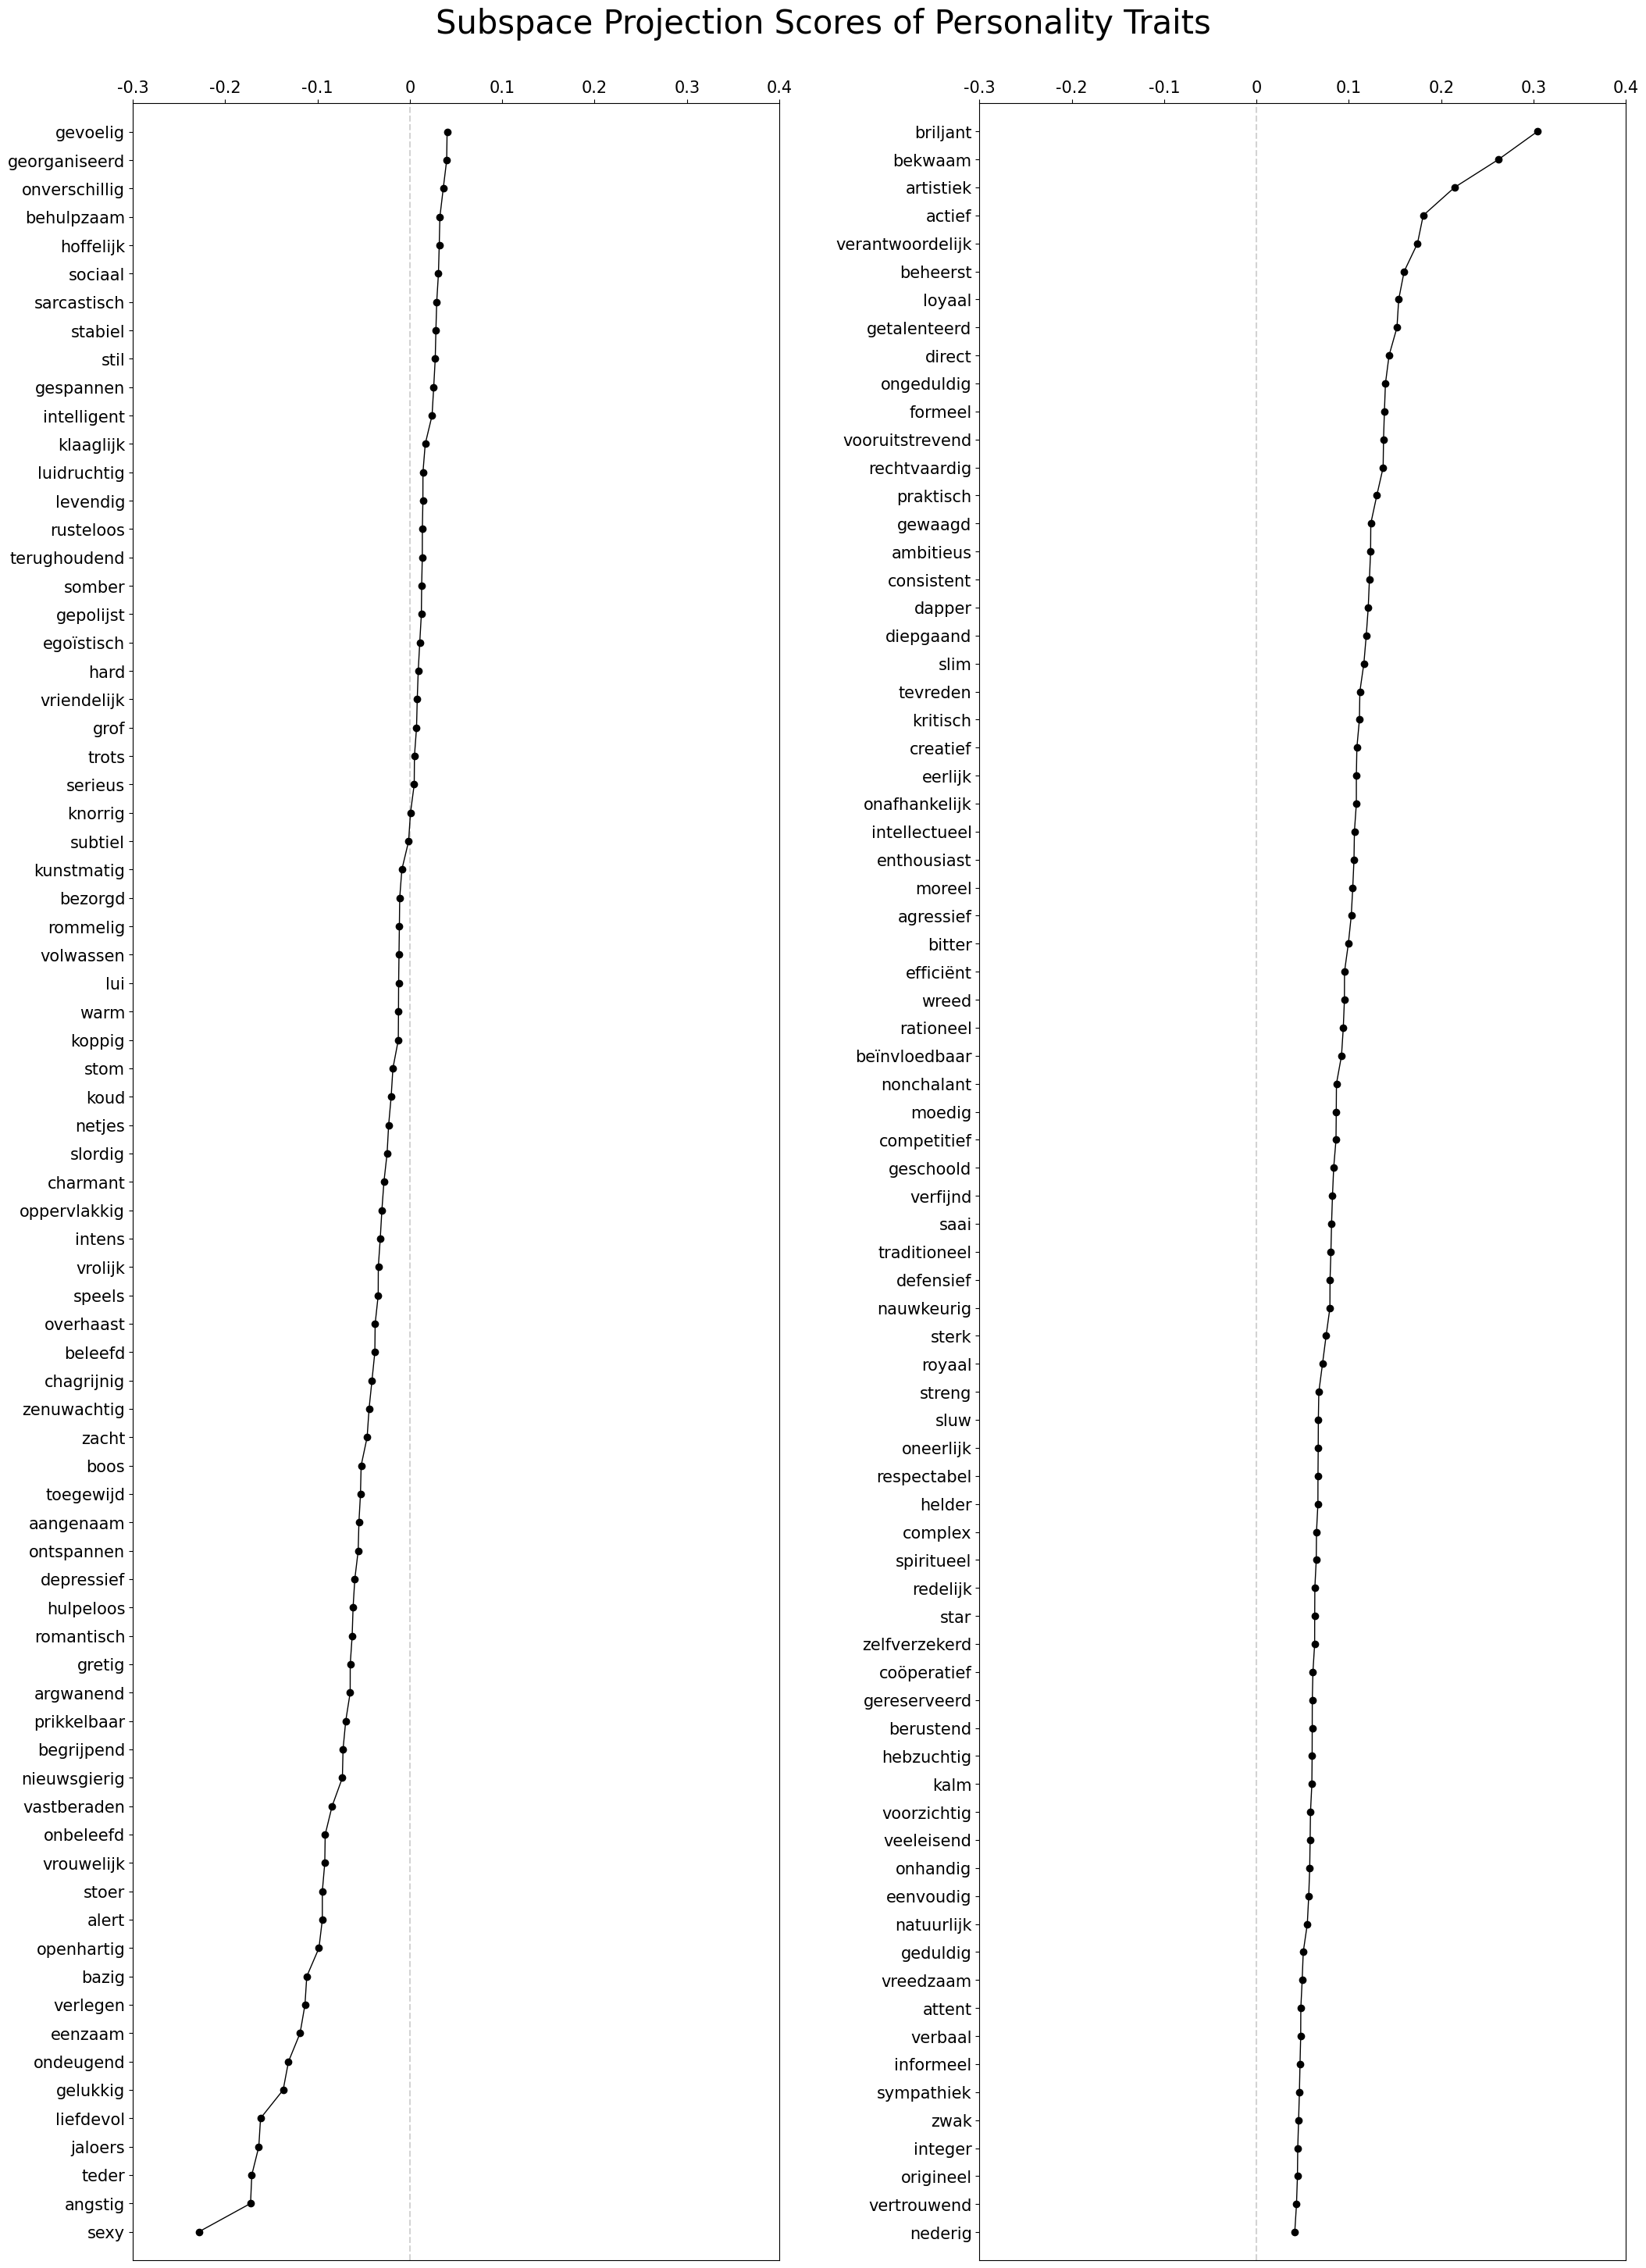

In [143]:
visualize_proj_of_words_to_genderspace(subspace_projection)

# Debiasing

We will perform debiasing on the embeddings that will make sure all words will be shifte

In [117]:
import copy
from debiaswe.debias import debias
"""
Hard-debias embedding
Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings
Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai
2016.
"""

gender_specific_words = gender_specific_man+gender_specific_woman

# Do a debiasing on the embeddings
debiased_E = copy.deepcopy(E)
equalize_pairs = [[w, m] for w, m in zip(gender_specific_woman,gender_specific_man)]
dwe.debias.debias(debiased_E, gender_specific_words, equalize_pairs, equalize_pairs)

# Create a Gensim KeyedVectors model
model = KeyedVectors(vector_size=debiased_E.vecs.shape[1])  # Replace `embedding_dim` with the dimensionality of your embeddings

# Add the word vectors and vocabulary to the model
model.add_vectors(debiased_E.words, debiased_E.vecs)  # Replace `debiased_E.words` with your list of words and `debiased_E.vecs` with your matrix of embeddings
debiased_E.model = model

now importing..
1043344 words of dimension 160 : \, \bar, \break, \clef, ..., ﺒ, －, ￡, ￥
{('vriendin', 'vriend'), ('PRESENTATRICE', 'PRESENTATOR'), ('KONINGIN', 'KONING'), ('ZUS', 'BROER'), ('zus', 'broer'), ('Vrouw', 'Man'), ('PRINSES', 'PRINS'), ('KLEINDOCHTER', 'KLEINZOON'), ('GROOTMOEDER', 'GROOTVADER'), ('kapster', 'kapper'), ('directrice', 'directeur'), ('Directrice', 'Directeur'), ('zij', 'hij'), ('DIRECTRICE', 'DIRECTEUR'), ('MOEDER', 'VADER'), ('ATLETE', 'ATLEET'), ('Prinses', 'Prins'), ('KAPSTER', 'KAPPER'), ('VRIENDIN', 'VRIEND'), ('Lerares', 'Leraar'), ('MEISJE', 'JONGEN'), ('oma', 'opa'), ('Kleindochter', 'Kleinzoon'), ('Nicht', 'Neef'), ('bruid', 'bruidegom'), ('OMA', 'OPA'), ('atlete', 'atleet'), ('ZUSSEN', 'BROERS'), ('Zij', 'Hij'), ('DOCHTER', 'ZOON'), ('haar', 'zijn'), ('Vriendin', 'Vriend'), ('Zus', 'Broer'), ('Mama', 'Papa'), ('grootmoeder', 'grootvader'), ('Kapster', 'Kapper'), ('kleindochter', 'kleinzoon'), ('zussen', 'broers'), ('Moeder', 'Vader'), ('prinses', 'p

In [ ]:
# # analogies gender
# a_gender = E.best_analogies_dist_thresh(v_gender)

# for (a,b,c) in a_gender:
#     print(a+"-"+b)
# WARNING this makes colab crash

In [118]:
# personality traits analysis gender
sp_debiased_after = ([(debiased_E.v(w).dot(v_gender), w) for w in personality_traits])

print("after debiasing", sp_debiased_after[0:20], sp_debiased_after[-20:])

sp_debiased_before = ([(E.v(w).dot(v_gender), w) for w in personality_traits])

print("before debiasing", sp_debiased_before[0:20], sp_debiased_before[-20:])

# personality traits analysis gender
sp_debiased_after = ([(debiased_E.v(w).dot(v_gender), w) for w in [ 'brandweer', 'rechter', 'arts']])

print("after debiasing", sp_debiased_after[0:20], sp_debiased_after[-20:])

sp_debiased_before = ([(E.v(w).dot(v_gender), w) for w in ['brandweer', 'rechter', 'arts']])

print("before debiasing", sp_debiased_before[0:20], sp_debiased_before[-20:])

after debiasing [(0.04597474, 'geschoold'), (0.060330108, 'angstig'), (0.056994863, 'verbaal'), (0.09458755, 'creatief'), (-0.0776683, 'voorzichtig'), (-0.098593995, 'direct'), (0.06419125, 'zelfverzekerd'), (-0.04326254, 'slordig'), (-0.12089953, 'gevoelig'), (-0.08756102, 'luidruchtig'), (0.07499283, 'onverschillig'), (0.02824741, 'beïnvloedbaar'), (0.117859244, 'dapper'), (-0.013700165, 'gereserveerd'), (0.097069494, 'getalenteerd'), (0.08914137, 'somber'), (-0.04626061, 'ontspannen'), (0.19773972, 'openhartig'), (0.030477706, 'zwak'), (0.081885904, 'sexy')] [(0.025656197, 'berustend'), (-0.06469777, 'actief'), (0.01224434, 'integer'), (0.02009837, 'aangenaam'), (0.007833559, 'georganiseerd'), (0.032003354, 'formeel'), (0.1313, 'nonchalant'), (0.07782207, 'defensief'), (0.062897384, 'behulpzaam'), (-0.031277265, 'veeleisend'), (0.019373503, 'toegewijd'), (0.02684964, 'natuurlijk'), (0.1397657, 'hebzuchtig'), (0.064220876, 'respectabel'), (0.09310071, 'nederig'), (0.038481284, 'gewaa

# Results
For evaluation we will calculate the difference for every personality trait between it's 10 most similar words before and after debiasing

Pseudo code:
Take the biased embeddings and for every personality trait in that embedding save the average distance to it's 10 most similar words.

Perform debiasing on the embedding

Take the debiased embedding and calculate the distances again for every personality trait and take the average.

Normalize the distances o

Now we can see how much this average changed.

Now make a plot where we see a distribution of words and their change of most similar words.

In [119]:
# Calculate average distance to 10 most similar words for each word in the list
def calculate_average_distances(embedding, word_list):
    average_distances = {}
    for trait in word_list:
        similar_words = embedding.model.most_similar(trait, topn=10)
        distances = [1 - score for _, score in similar_words]  # Convert similarity scores to distances
        average_distances[trait] = np.mean(distances)
    return average_distances


# Plot the distribution of words and their change in most similar words
def plot_word_change_distribution(original_distances, debiased_distances):
    fig, ax = plt.subplots(figsize=(12, 24))
    traits = original_distances.keys()
    y = np.arange(len(traits))
    width = 0.35
    spacing = 0.8
    ax.barh(y - width/2, original_distances.values(), height=width, label='Original')
    ax.barh(y + width/2, debiased_distances.values(), height=width, label='Debiased')
    ax.set_yticks(y)
    ax.set_yticklabels(traits, fontsize=10)
    ax.set_ylabel('Personality Traits', fontsize=14)
    ax.set_xlabel('Average Distance to Most Similar Words', fontsize=14)
    ax.set_title('Similarity distance of original and debiased embeddings', fontsize=16, pad=24)
    ax.legend()
    plt.subplots_adjust(top=0.97, bottom=0.1)
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Visualisaties/similarity_scores.png", dpi=300)
    plt.show()


# Plot the distribution of distances with the number of words within each distance bin
def plot_distance_distribution(distances):
    plt.figure(figsize=(10, 6))
    normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
    n, bins, patches = plt.hist(normalized_distances, bins=10, alpha=0.7, rwidth=0.85)
    plt.xlabel('Normalized Distance')
    plt.ylabel('Number of Words')
    plt.title('Distribution of Normalized Average Distances of 10 most similar words before and after debiasing')
    plt.tight_layout()

    # Add labels to the histogram bars
    for i in range(len(patches)):
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(),
                 str(int(n[i])), ha='center', va='bottom')
    plt.show()

In [120]:
original_embedding = E
debiased_embedding = debiased_E
# personality_traits = personality_traits_man + personality_traits_woman

original_distances = calculate_average_distances(original_embedding, personality_traits)
debiased_distances = calculate_average_distances(debiased_embedding, personality_traits)

original_distances = dict(list(original_distances.items())[len(original_distances)//2:])
debiased_distances = dict(list(debiased_distances.items())[len(debiased_distances)//2:])

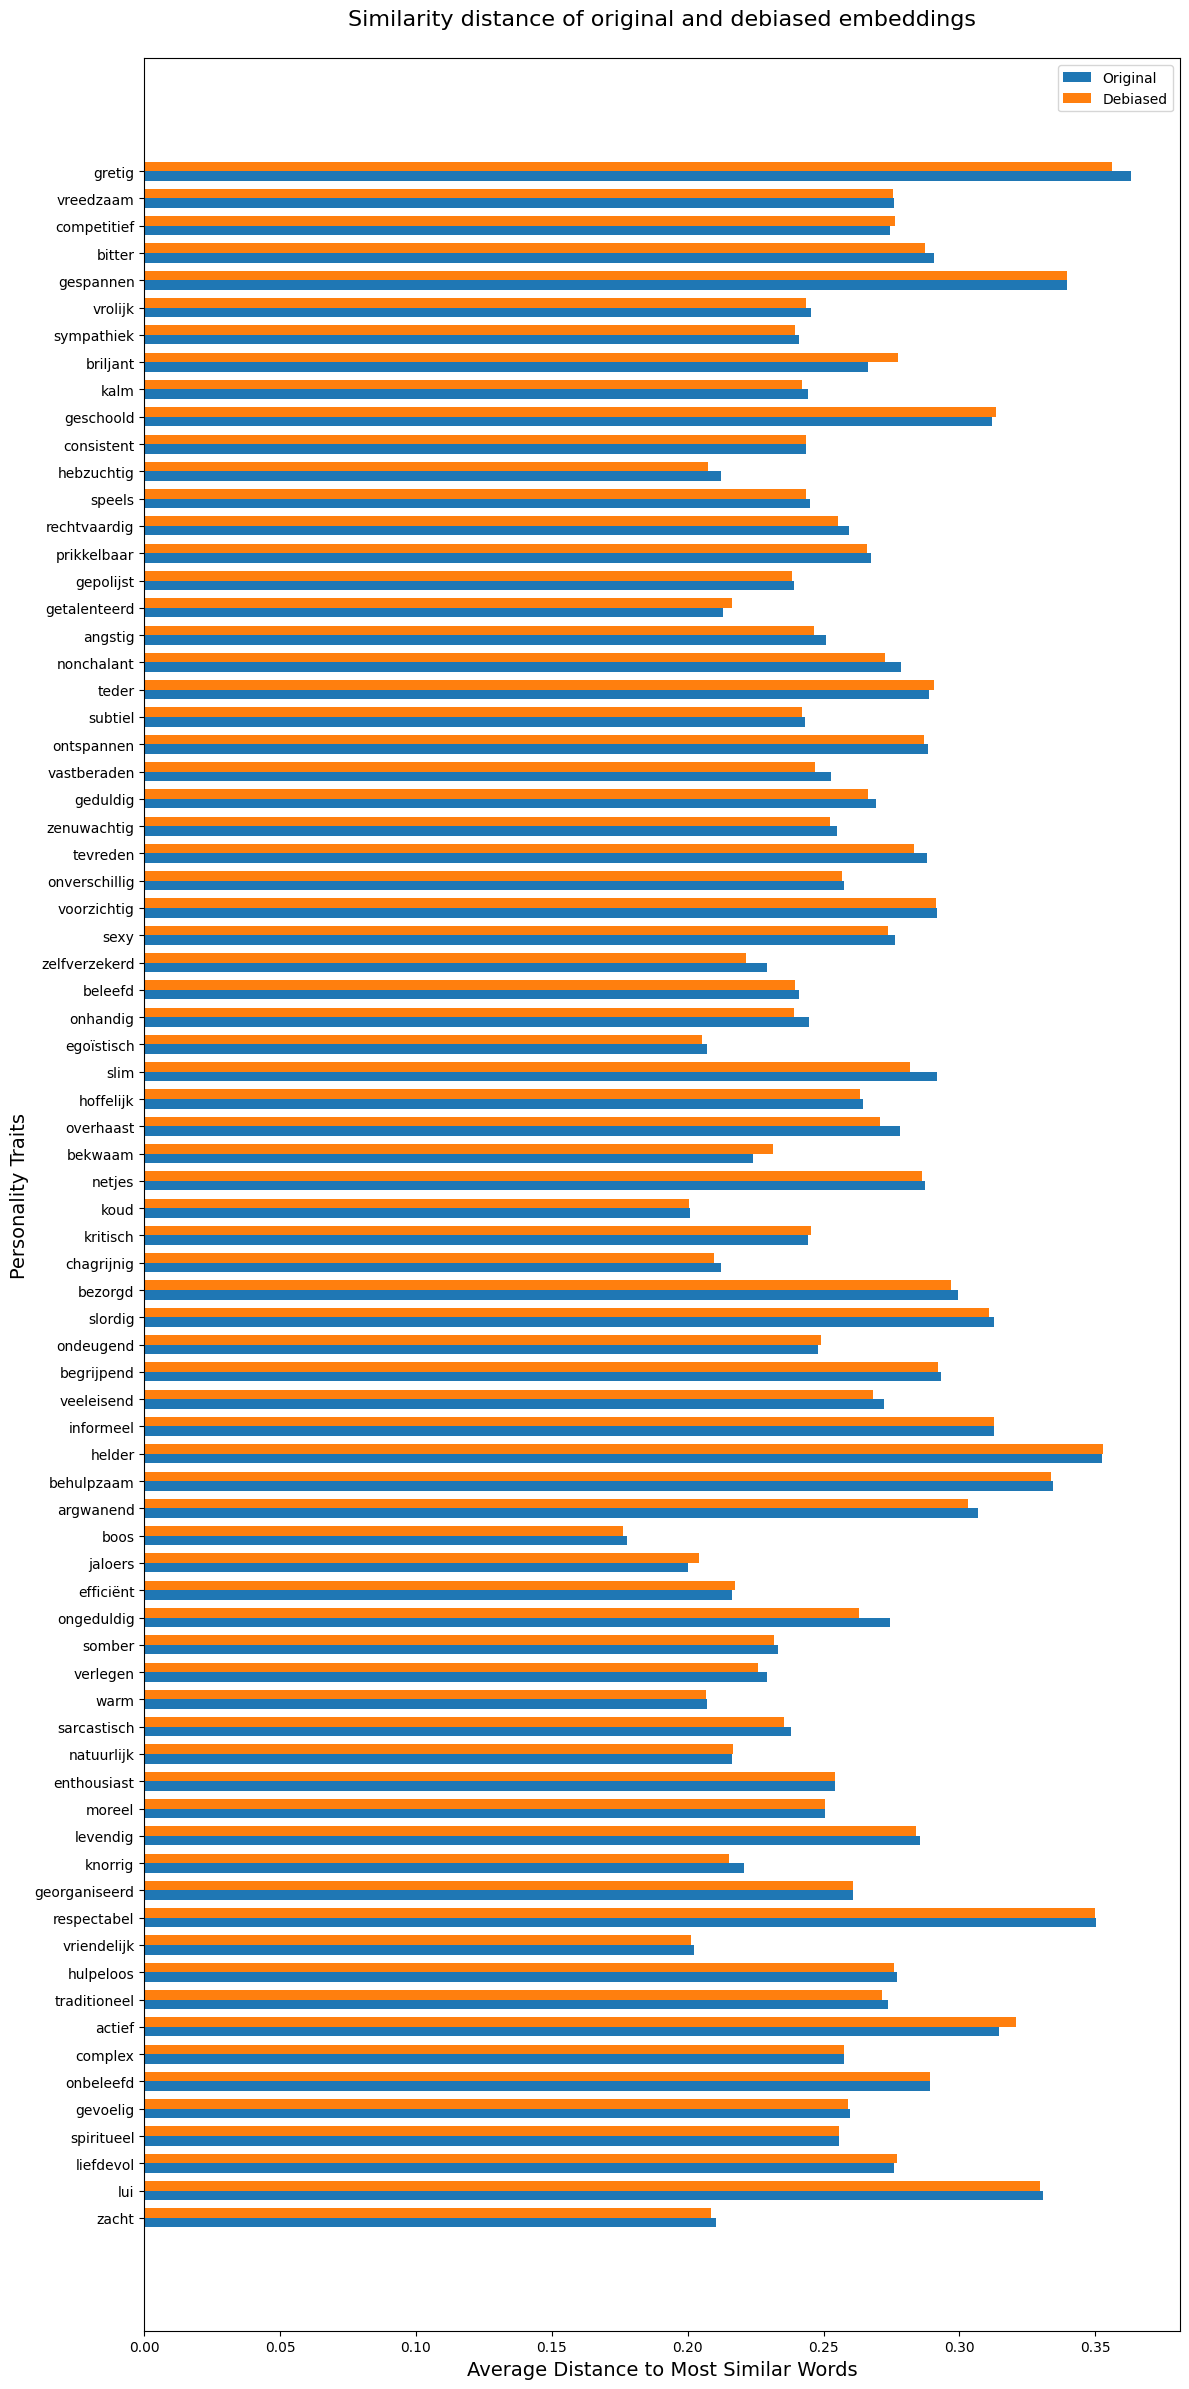

In [ ]:
plot_word_change_distribution(original_distances, debiased_distances)

In [140]:
# Plot the distribution of words and their change in most similar words
def plot_word_change_distribution(original_distances, debiased_distances):
    fig, ax = plt.subplots(figsize=(24, 12))
    traits = original_distances.keys()
    y = np.arange(len(traits))
    width = 0.35
    spacing = 0.8
    ax.bar(y - width/2, original_distances.values(), width, label='Original')
    ax.bar(y + width/2, debiased_distances.values(), width, label='Debiased')
    ax.set_xticks(y)
    ax.set_xticklabels(traits, fontsize=14, rotation='vertical')
    ax.set_xlabel('Personality Traits', fontsize=20)
    ax.set_ylabel('Average Distance', fontsize=20)
    ax.set_title('Average Distance of Original and Debiased Embeddings to Most Similar Words', fontsize=30, pad=40)
    ax.legend(fontsize=18)
    plt.subplots_adjust(top=0.97, bottom=0.1)
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Visualisaties/similarity_scores.png", dpi=300)
    plt.show()

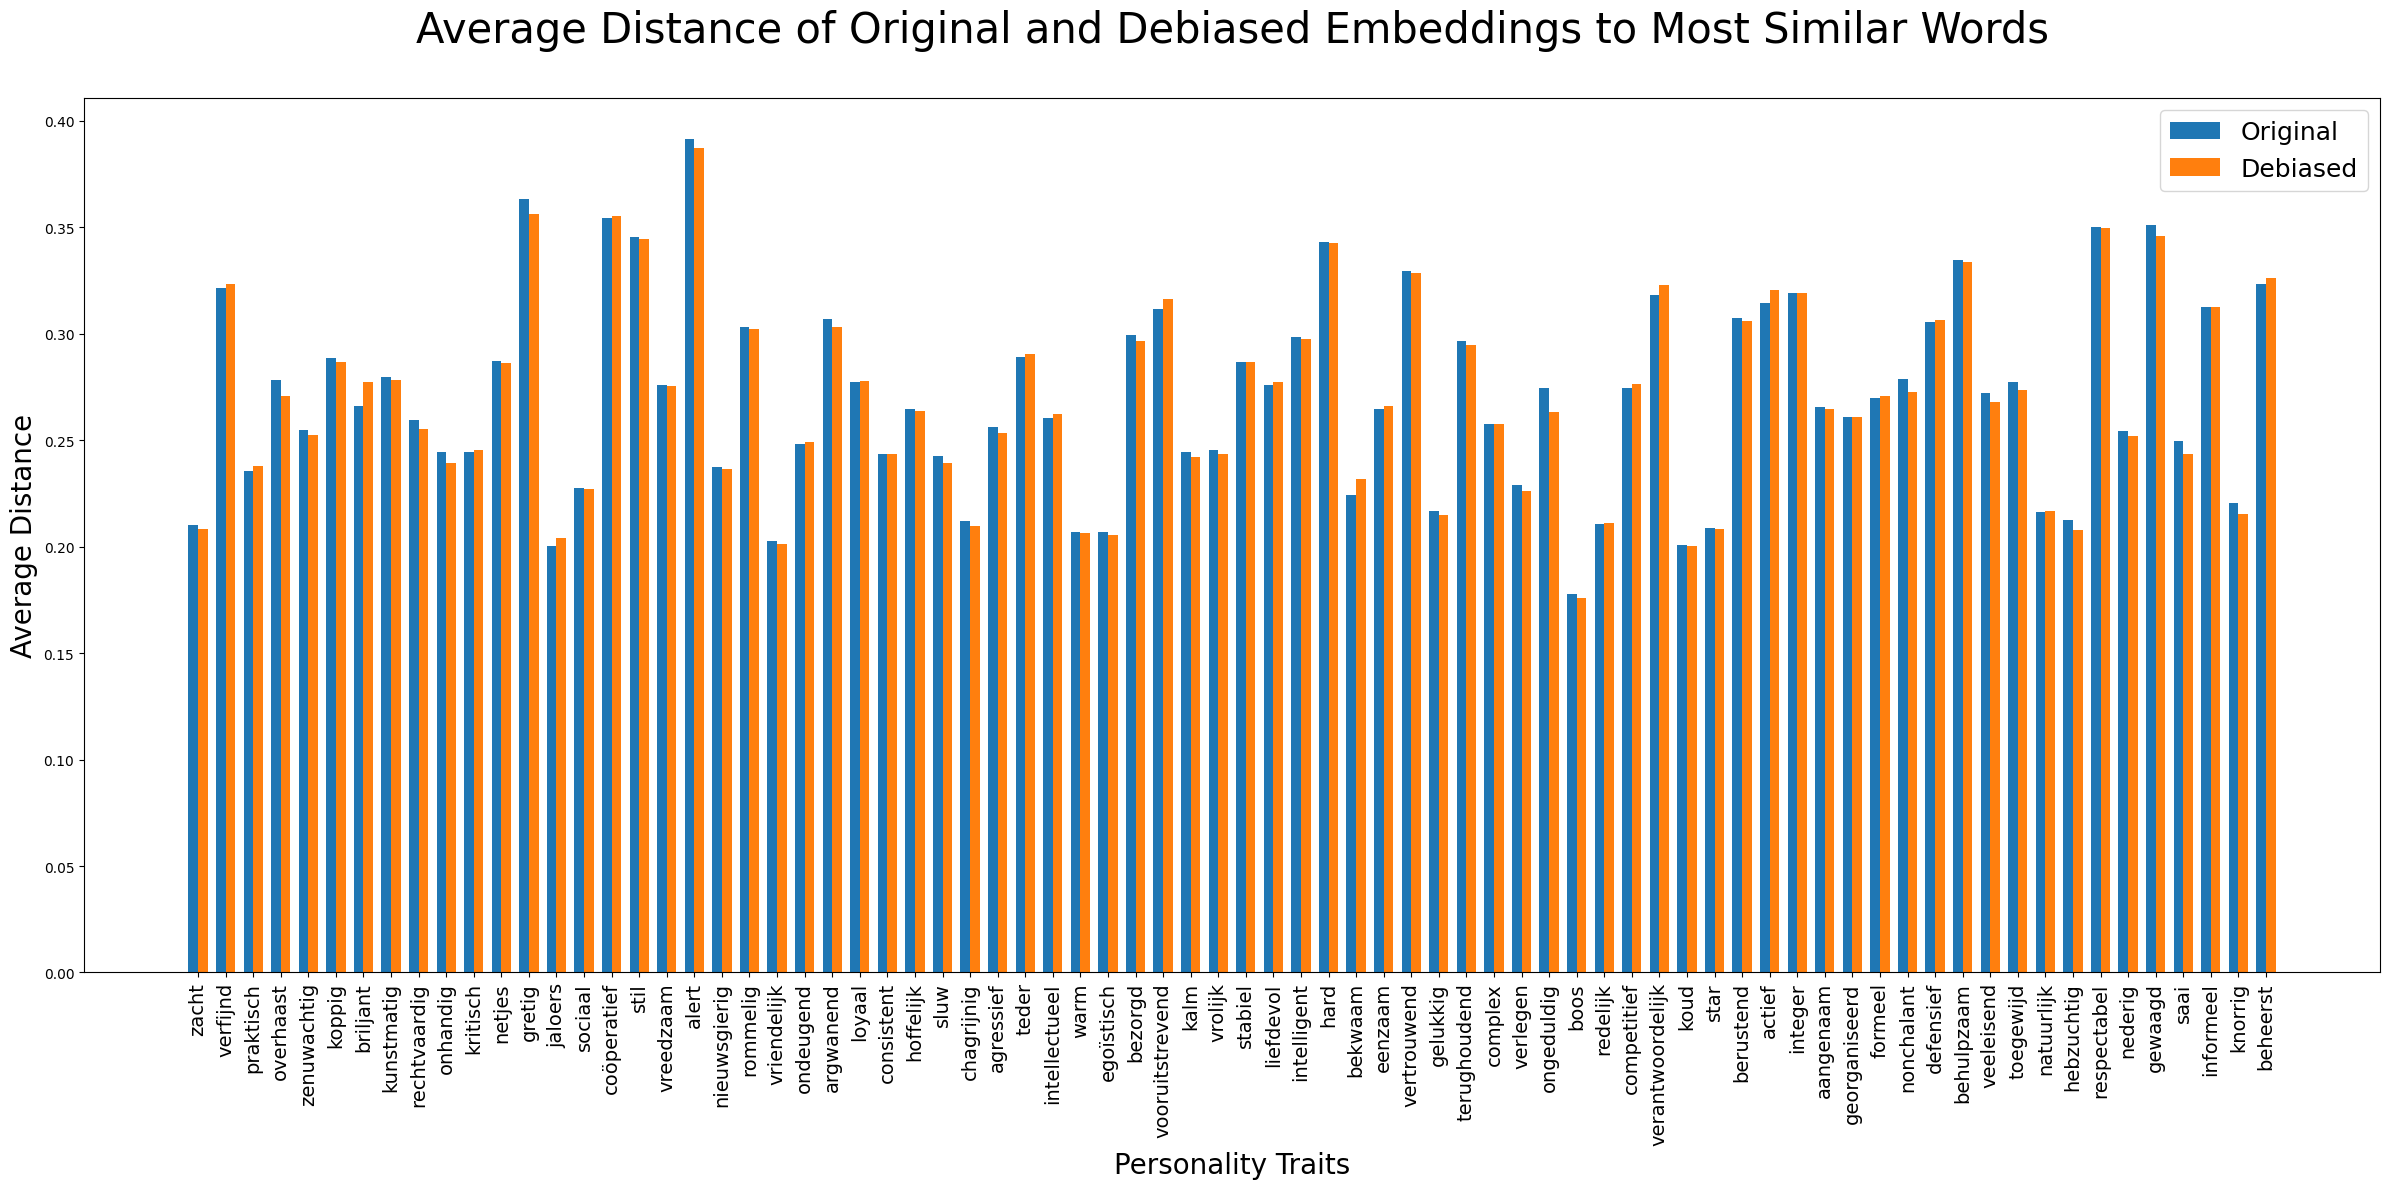

In [141]:
plot_word_change_distribution(original_distances, debiased_distances)

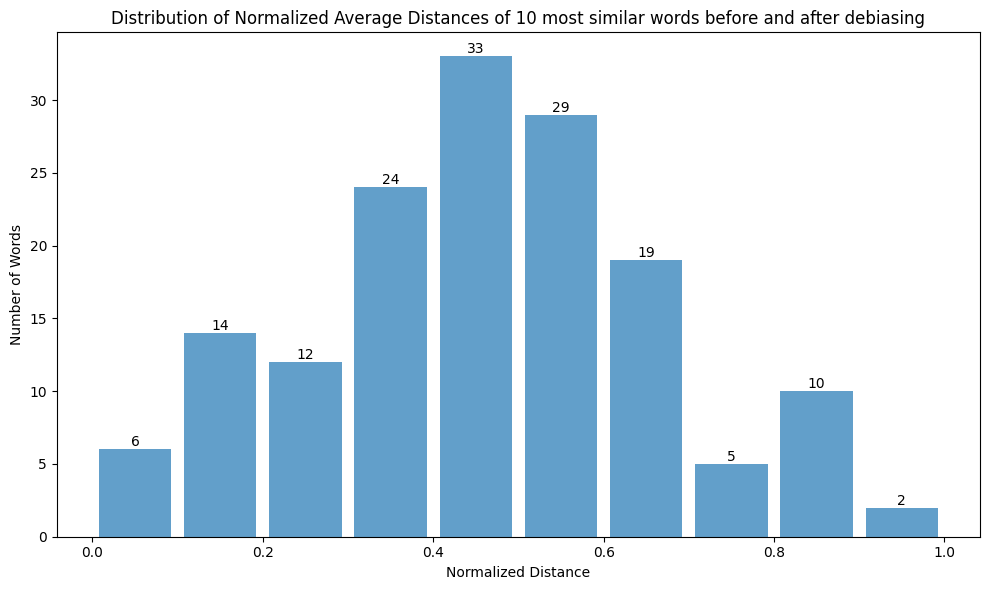

In [ ]:
# Extract distances from the dictionaries
original_distance_values = list(original_distances.values())
debiased_distance_values = list(debiased_distances.values())

# Combine the distances for the distribution plot
all_distances = original_distance_values + debiased_distance_values

plot_distance_distribution(all_distances)

From this plot

We check the distribution also for random words.

In [ ]:
s=E.words[::1000]
original_distances = calculate_average_distances(original_embedding, E.words[::500])
debiased_distances = calculate_average_distances(debiased_embedding, debiased_E.words[::500])

KeyboardInterrupt: ignored

In [ ]:
original_distance_values = list(original_distances.values())
debiased_distance_values = list(debiased_distances.values())

# Combine the distances for the distribution plot
all_distances = original_distance_values + debiased_distance_values

plot_distance_distribution(all_distances)


# Visualization after debiasing
Now we can make the same visualisations but after debiasing to see if it worked.

In [ ]:
man_direction = gender_direction - gender_direction/2
woman_direction = - gender_direction/2
gender_specific_man_with_flags = ["-m " + w for w in gender_specific_man]
gender_specific_woman_with_flags = ["-v " + w for w in gender_specific_woman]
gender_specific_man_embeddings = [debiased_E.model[w] for w in gender_specific_man] + [man_direction.reshape((160,))]
gender_specific_woman_embeddings = [debiased_E.model[w] for w in gender_specific_woman] + [woman_direction.reshape((160,))]

save_embeddings_for_visualisation("DeB_emb_gender_specific_words_and_gender_direction", "DeB_meta_gender_specific_words_and_gender_direction",
                                  gender_specific_man_with_flags + ["-m GENDER DIRECTION MALE"] + gender_specific_woman_with_flags + ["-v GENDER DIRECTION FEMALE"],
                                  gender_specific_man_embeddings + gender_specific_woman_embeddings, gender_specific=True)

In [ ]:
personality_traits_man_with_flags = ["-m " + w for w in personality_traits_man]
personality_traits_woman_with_flags = ["-v " + w for w in personality_traits_woman]
personality_traits_man_embeddings = [debiased_E.model[w] for w in personality_traits_man] + [man_direction.reshape((160,))]
personality_traits_woman_embeddings = [debiased_E.model[w] for w in personality_traits_woman] + [woman_direction.reshape((160,))]

save_embeddings_for_visualisation("DeB_emb_personality_traits_words_and_gender_direction", "DeB_meta_personality_traits_words_and_gender_direction",
                                  personality_traits_man_with_flags + ["-m GENDER DIRECTION MALE"] + personality_traits_woman_with_flags + ["-v GENDER DIRECTION FEMALE"],
                                  personality_traits_man_embeddings + personality_traits_woman_embeddings, gender_specific=True, personality=True)

We will make different tensorboard visualizations f

In [ ]:
# Matplotlib plot of embeddings
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming you have the following variables:
# E: Original word2vec model
# debiased_E: Debiased word2vec model
# gender_specific_man: List of gender-specific words for men
# gender_specific_woman: List of gender-specific words for women
# personality_traits_man: List of personality trait words for men
# personality_traits_woman: List of personality trait words for women

# Define the colors for each group
personality_man_color = '#FFB74D'  # Orange
personality_woman_color = '#FF80AB'  # Pink
personality_man_debiased_color = '#FFD180'  # Light orange
personality_woman_debiased_color = '#FFC1E3'  # Light pink

# Function to extract embeddings for a given list of words from a word2vec model
def get_embeddings(e_model, words):
    embeddings = []
    for word in words:
        if word in e_model.words:
            embeddings.append(e_model.model[word])
    return np.array(embeddings)

# Extract original embeddings for personality trait words
man_personality_embeddings = get_embeddings(E, personality_traits_man)
woman_personality_embeddings = get_embeddings(E, personality_traits_woman)
man_personality_debiased_embeddings = get_embeddings(debiased_E, personality_traits_man)
woman_personality_debiased_embeddings = get_embeddings(debiased_E, personality_traits_woman)

# Concatenate the original and debiased embeddings
all_embeddings = np.concatenate((
    man_personality_embeddings,
    woman_personality_embeddings,
    man_personality_debiased_embeddings,
    woman_personality_debiased_embeddings
))

# Perform dimensionality reduction using PCA
pca = PCA(n_components=3)
all_embeddings_pca = pca.fit_transform(all_embeddings)

# Split the embeddings into different groups
man_personality_embeddings_pca = all_embeddings_pca[:len(man_personality_embeddings), :]
woman_personality_embeddings_pca = all_embeddings_pca[len(man_personality_embeddings):len(man_personality_embeddings)+len(woman_personality_embeddings), :]
man_personality_debiased_embeddings_pca = all_embeddings_pca[len(woman_personality_embeddings_pca):len(woman_personality_embeddings_pca)+len(man_personality_debiased_embeddings), :]
woman_personality_debiased_embeddings_pca = all_embeddings_pca[len(man_personality_embeddings_pca):, :]

# Plot the embeddings
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Original embeddings
ax.scatter(man_personality_embeddings_pca[:, 0], man_personality_embeddings_pca[:, 1], man_personality_embeddings_pca[:, 2], color=personality_man_color, alpha=0.5, label='Personality Traits (Men)')
ax.scatter(woman_personality_embeddings_pca[:, 0], woman_personality_embeddings_pca[:, 1], woman_personality_embeddings_pca[:, 2], color=personality_woman_color, alpha=0.5, label='Personality Traits (Women)')

# Debiased embeddings
ax.scatter(man_personality_debiased_embeddings_pca[:, 0], man_personality_debiased_embeddings_pca[:, 1], man_personality_debiased_embeddings_pca[:, 2], color=personality_man_debiased_color, alpha=0.25, label='Personality Traits Debiased (Men)')
ax.scatter(woman_personality_debiased_embeddings_pca[:, 0], woman_personality_debiased_embeddings_pca[:, 1], woman_personality_debiased_embeddings_pca[:, 2], color=personality_woman_debiased_color, alpha=0.25, label='Personality Traits Debiased (Women)')

# Plot the gender subspace line
subspace_start = pca.mean_
subspace_end = subspace_start + debiased_E.model['meisje'] - debiased_E.model['jongen']
ax.plot([subspace_start[0], subspace_end[0]], [subspace_start[1], subspace_end[1]], [subspace_start[2], subspace_end[2]], color='black', linestyle='--', linewidth=2, label='Gender Subspace')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Word Embeddings Visualization')
ax.legend()
plt.show()


SyntaxError: ignored

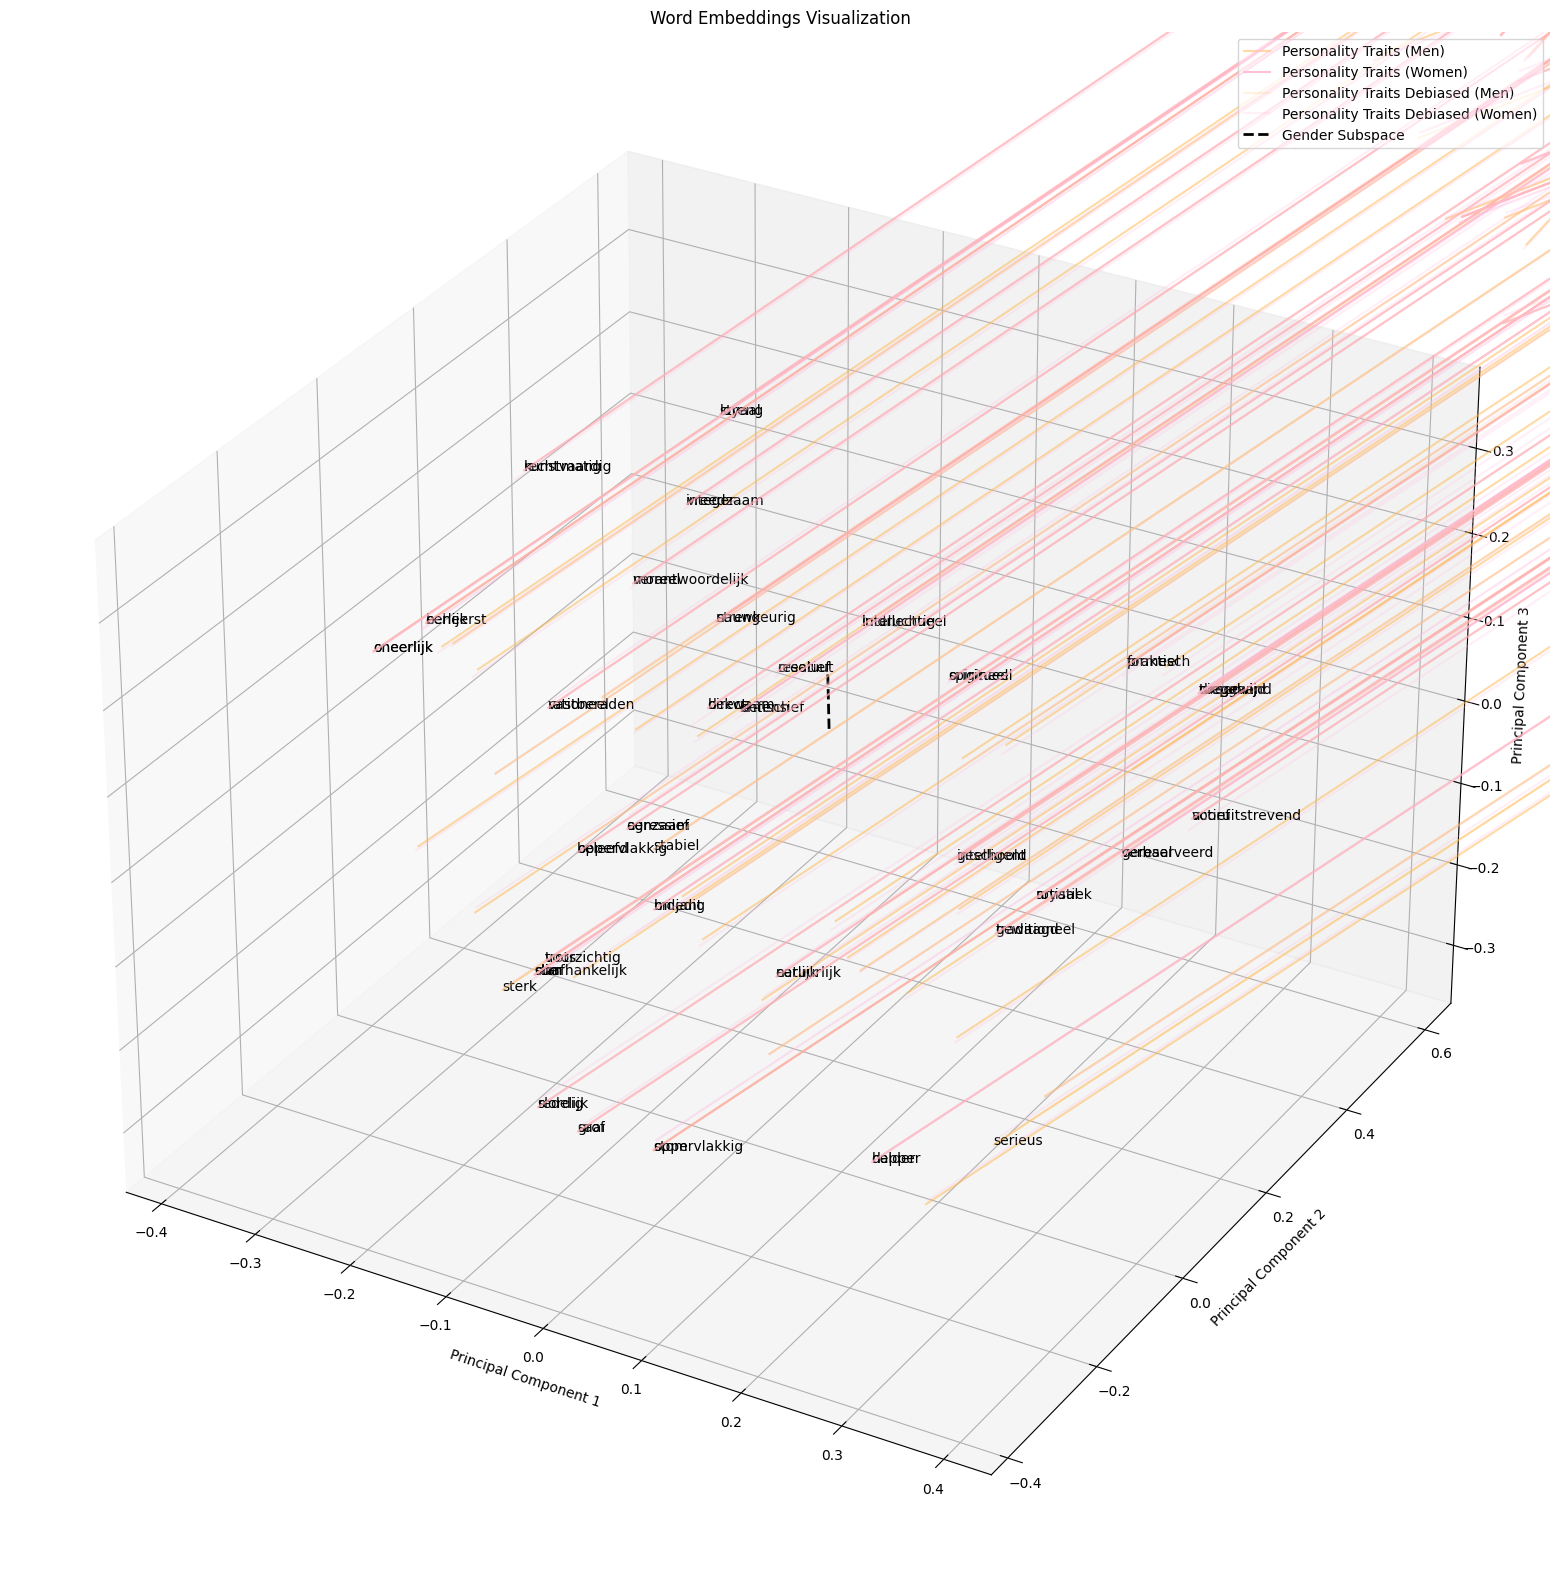

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming you have the following variables:
# E: Original word2vec model
# debiased_E: Debiased word2vec model
# gender_specific_man: List of gender-specific words for men
# gender_specific_woman: List of gender-specific words for women
# personality_traits_man: List of personality trait words for men
# personality_traits_woman: List of personality trait words for women

# Define the colors for each group
personality_man_color = '#FFB74D'  # Orange
personality_woman_color = '#FF80AB'  # Pink
personality_man_debiased_color = '#FFD180'  # Light orange
personality_woman_debiased_color = '#FFC1E3'  # Light pink

# Function to extract embeddings for a given list of words from a word2vec model
def get_embeddings(e_model, words):
    embeddings = []
    for word in words:
        if word in e_model.words:
            embeddings.append(e_model.model[word])
    return np.array(embeddings)

# Extract original embeddings for personality trait words
man_personality_embeddings = get_embeddings(E, personality_traits_man)
woman_personality_embeddings = get_embeddings(E, personality_traits_woman)
man_personality_debiased_embeddings = get_embeddings(debiased_E, personality_traits_man)
woman_personality_debiased_embeddings = get_embeddings(debiased_E, personality_traits_woman)

# Concatenate the original and debiased embeddings
all_embeddings = np.concatenate((
    man_personality_embeddings,
    woman_personality_embeddings,
    man_personality_debiased_embeddings,
    woman_personality_debiased_embeddings
))

# Perform dimensionality reduction using PCA
pca = PCA(n_components=3)
all_embeddings_pca = pca.fit_transform(all_embeddings)

# Split the embeddings into different groups
man_personality_embeddings_pca = all_embeddings_pca[:len(man_personality_embeddings), :]
woman_personality_embeddings_pca = all_embeddings_pca[len(man_personality_embeddings):len(man_personality_embeddings)+len(woman_personality_embeddings), :]
man_personality_debiased_embeddings_pca = all_embeddings_pca[len(woman_personality_embeddings_pca):len(woman_personality_embeddings_pca)+len(man_personality_debiased_embeddings), :]
woman_personality_debiased_embeddings_pca = all_embeddings_pca[len(man_personality_embeddings_pca):, :]

# Plot the embeddings
fig = plt.figure(figsize=(100, 20))
ax = fig.add_subplot(111, projection='3d')

# Original embeddings
ax.quiver(man_personality_embeddings_pca[:, 0], man_personality_embeddings_pca[:, 1], man_personality_embeddings_pca[:, 2],
          np.ones_like(man_personality_embeddings_pca[:, 0]), np.ones_like(man_personality_embeddings_pca[:, 1]), np.ones_like(man_personality_embeddings_pca[:, 2]),
          color=personality_man_color, alpha=0.5, label='Personality Traits (Men)')
ax.quiver(woman_personality_embeddings_pca[:, 0], woman_personality_embeddings_pca[:, 1], woman_personality_embeddings_pca[:, 2],
          np.ones_like(woman_personality_embeddings_pca[:, 0]), np.ones_like(woman_personality_embeddings_pca[:, 1]), np.ones_like(woman_personality_embeddings_pca[:, 2]),
          color=personality_woman_color, alpha=0.5, label='Personality Traits (Women)')

# Debiased embeddings
ax.quiver(man_personality_debiased_embeddings_pca[:, 0], man_personality_debiased_embeddings_pca[:, 1], man_personality_debiased_embeddings_pca[:, 2],
          np.ones_like(man_personality_debiased_embeddings_pca[:, 0]), np.ones_like(man_personality_debiased_embeddings_pca[:, 1]), np.ones_like(man_personality_debiased_embeddings_pca[:, 2]),
          color=personality_man_debiased_color, alpha=0.25, label='Personality Traits Debiased (Men)')
ax.quiver(woman_personality_debiased_embeddings_pca[:, 0], woman_personality_debiased_embeddings_pca[:, 1], woman_personality_debiased_embeddings_pca[:, 2],
          np.ones_like(woman_personality_debiased_embeddings_pca[:, 0]), np.ones_like(woman_personality_debiased_embeddings_pca[:, 1]), np.ones_like(woman_personality_debiased_embeddings_pca[:, 2]),
          color=personality_woman_debiased_color, alpha=0.25, label='Personality Traits Debiased (Women)')

# Plot the gender subspace line
subspace_start = pca.mean_
subspace_end = subspace_start + debiased_E.model['zij'] - debiased_E.model['hij']
ax.plot([subspace_start[0], subspace_end[0]], [subspace_start[1], subspace_end[1]], [subspace_start[2], subspace_end[2]],
        color='black', linestyle='--', linewidth=2, label='Gender Subspace')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Word Embeddings Visualization')

# Show the words using Debiased_E.model["word"]
for word, x, y, z in zip(personality_traits_man, man_personality_debiased_embeddings_pca[:, 0],
                        man_personality_debiased_embeddings_pca[:, 1], man_personality_debiased_embeddings_pca[:, 2]):
    ax.text(x, y, z, word, color='black')
for word, x, y, z in zip(personality_traits_woman, woman_personality_debiased_embeddings_pca[:, 0],
                        woman_personality_debiased_embeddings_pca[:, 1], woman_personality_debiased_embeddings_pca[:, 2]):
    ax.text(x, y, z, word, color='black')

# Add the legend
ax.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming you have the following variables:
# E: Original word2vec model
# debiased_E: Debiased word2vec model
# gender_specific_man: List of gender-specific words for men
# gender_specific_woman: List of gender-specific words for women
# personality_traits_man: List of personality trait words for men
# personality_traits_woman: List of personality trait words for women

# Define the colors for each group
colors = {
    'gender_specific_man': '#0099ff',  # Blue
    'gender_specific_woman': '#ff66cc',  # Pink
    'personality_man': '#0033cc',  # Dark blue
    'personality_woman': '#ff3399',  # Magenta
    'gender_specific_man_debiased': '#66ccff',  # Light blue
    'gender_specific_woman_debiased': '#ffb3e6',  # Light pink
    'personality_man_debiased': '#99ccff',  # Light blue
    'personality_woman_debiased': '#ff99cc'  # Light pink
}

# Function to extract embeddings for a given list of words from a word2vec model
def get_embeddings(e_model, words):
    return np.array([e_model[word] for word in words if word in e_model.vocab])

# Extract original embeddings for gender-specific and personality trait words
man_specific_embeddings = get_embeddings(E, gender_specific_man)
woman_specific_embeddings = get_embeddings(E, gender_specific_woman)
man_personality_embeddings = get_embeddings(E, personality_traits_man)
woman_personality_embeddings = get_embeddings(E, personality_traits_woman)

# Extract debiased embeddings for gender-specific and personality trait words
man_specific_debiased_embeddings = get_embeddings(debiased_E, gender_specific_man)
woman_specific_debiased_embeddings = get_embeddings(debiased_E, gender_specific_woman)
man_personality_debiased_embeddings = get_embeddings(debiased_E, personality_traits_man)
woman_personality_debiased_embeddings = get_embeddings(debiased_E, personality_traits_woman)

# Perform dimensionality reduction using PCA
pca = PCA(n_components=3)
embeddings = np.concatenate((
    man_specific_embeddings,
    woman_specific_embeddings,
    man_personality_embeddings,
    woman_personality_embeddings,
    man_specific_debiased_embeddings,
    woman_specific_debiased_embeddings,
    man_personality_debiased_embeddings,
    woman_personality_debiased_embeddings
))
all_embeddings_pca = pca.fit_transform(embeddings)

# Define the labels for the legend
labels = {
    'gender_specific_man': 'Gender-Specific (Men)',
    'gender_specific_woman': 'Gender-Specific (Women)',
    'personality_man': 'Personality Traits (Men)',
    'personality_woman': 'Personality Traits (Women)',
    'gender_specific_man_debiased': 'Gender-Specific Debiased (Men)',
    'gender_specific_woman_debiased': 'Gender-Specific Debiased (Women)',
    'personality_man_debiased': 'Personality Traits Debiased (Men)',
    'personality_woman_debiased': 'Personality Traits Debiased (Women)'
}

# Plot the embeddings
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the embeddings for each group
for group, embeddings_pca in zip(labels.keys(), np.split(all_embeddings_pca, 8)):
    color = colors[group]
    label = labels[group]
    alpha = 0.5 if 'debiased' in group else 1.0
    ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], color=color, alpha=alpha, label=label)

# Plot the gender subspace line
subspace_start = pca.mean_
subspace_end = subspace_start + debiased_E['man'] - debiased_E['woman']
ax.plot([subspace_start[0], subspace_end[0]], [subspace_start[1], subspace_end[1]], [subspace_start[2], subspace_end[2]], color='black', linestyle='--', linewidth=2, label='Gender Subspace')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add the legend
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

NameError: ignored

In [ ]:
# personality traits analysis gender
subspace_projection = sorted([(debiased_E.v(w).dot(v_gender), w) for w in personality_traits_woman+personality_traits_man])

subspace_projection[0:20], subspace_projection[-20:]

([(-0.3733978, 'volwassen'),
  (-0.12697995, 'nauwkeurig'),
  (-0.110311925, 'luidruchtig'),
  (-0.10497326, 'zacht'),
  (-0.10497326, 'zacht'),
  (-0.09636293, 'voorzichtig'),
  (-0.09437432, 'stabiel'),
  (-0.061254546, 'slordig'),
  (-0.059237983, 'onafhankelijk'),
  (-0.05837077, 'koud'),
  (-0.05758774, 'taai'),
  (-0.0512233, 'competitief'),
  (-0.05101325, 'sterk'),
  (-0.04357143, 'praktisch'),
  (-0.04150274, 'kunstmatig'),
  (-0.0084849, 'sociaal'),
  (-0.008387234, 'gepolijst'),
  (-0.0073602833, 'informeel'),
  (-0.0034931507, 'grof'),
  (-0.0010938933, 'verantwoordelijk')],
 [(0.051502727, 'oneerlijk'),
  (0.053448223, 'terughoudend'),
  (0.060651843, 'creatief'),
  (0.06368364, 'gelukkig'),
  (0.066332534, 'behulpzaam'),
  (0.070510164, 'lui'),
  (0.07114438, 'bezorgd'),
  (0.07114438, 'bezorgd'),
  (0.07163815, 'somber'),
  (0.072303385, 'slim'),
  (0.075662784, 'vrolijk'),
  (0.080767386, 'beleefd'),
  (0.080767386, 'beleefd'),
  (0.08220925, 'star'),
  (0.08808641, 'vr

In [ ]:
print(E.model.most_similar("mooi", topn=100))
print(debiased_E.model.most_similar("mooi", topn=100))

NameError: ignored

In [ ]:
# CODE FOR identifying the gender subspace

# Calculate differences for every gender-specific word-pair e.g. oom-tante
diff_emb = [model[m] - model[v] for m, v in zip(gender_specific_man, gender_specific_woman)]
# Save the words as meta data
diff_meta = [f"{m} - {v}" for m, v in zip(gender_specific_man, gender_specific_woman)]

# Save the embeddings in two files for visualisation.
# Do not forget to specify the correct location in the function
# or as argument in the optional os_path variable
save_embeddings_for_visualisation("diff_emb_gendered_words", "diff_meta_gendered_words", diff_meta, diff_emb)

genderspecific_emb = [model[w] for w in gender_specific_man + gender_specific_woman]
genderspecific_meta = gender_specific_man+gender_specific_woman
genderspecific_meta = [f"{w}\tmannelijk" for w in gender_specific_man]+[f"{w}\tvrouwelijk" for w in gender_specific_woman]

save_embeddings_for_visualisation("diff_and_genderspecific_emb", "diff_and_genderspecific_meta", diff_meta+genderspecific_meta, diff_emb+genderspecific_emb)

# Perform PCA on these words to find the gender subspace:
gender_subspace = doPCA(zip(gender_specific_man, gender_specific_woman), model)



In [ ]:
# gender_subspace = model['meisje'] - model['jongen']
# gender_subspace.explained_variance_ratio_

https://medium.com/mlearning-ai/getting-contextualized-word-embeddings-with-bert-20798d8b43a4 for visualisations

In [ ]:
# Save embeddings and their tokens in seperate list
words = ['meisje', 'jongen']
embeddings =[model['meisje'], model['jongen']]

Visualise the gender subspace (for now see tensorboard)



Now we want to subtract the projections onto the subspace from the embeddings to do a hard debiasing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming you have the following variables:
# personality_words: List of personality trait words
# personality_embeddings: List of corresponding word embeddings
# debiased_embeddings: List of debiased word embeddings
# gender_subspace_embedding: Gender subspace embedding (difference vector)
personality_embeddings = [E.model[w] for w in personality_traits_man+personality_traits_woman]

# Concatenate the original and debiased embeddings
all_embeddings = np.concatenate((personality_embeddings, debiased_embeddings), axis=0)

# Perform dimensionality reduction using PCA
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)

# Split the embeddings into original and debiased parts
original_embeddings_pca = all_embeddings_pca[:len(personality_words), :]
debiased_embeddings_pca = all_embeddings_pca[len(personality_words):, :]

# Plot the word vectors in the vector space
plt.figure(figsize=(10, 10))
plt.scatter(original_embeddings_pca[:, 0], original_embeddings_pca[:, 1], c='blue', alpha=0.5, label='Original')
plt.scatter(debiased_embeddings_pca[:, 0], debiased_embeddings_pca[:, 1], c='orange', alpha=0.5, label='Debiased')

# Plot the gender subspace as a line
subspace_start = np.mean(original_embeddings_pca, axis=0)
subspace_end = subspace_start + gender_subspace_embedding
plt.plot([subspace_start[0], subspace_end[0]], [subspace_start[1], subspace_end[1]], c='red', linestyle='--', label='Gender Subspace')

# Add labels to the points
for i, word in enumerate(personality_words):
    plt.annotate(word, (original_embeddings_pca[i, 0], original_embeddings_pca[i, 1]), fontsize=8, color='blue')
    plt.annotate(word, (debiased_embeddings_pca[i, 0], debiased_embeddings_pca[i, 1]), fontsize=8, color='orange')

# Set labels and show the plot
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Personality Trait Word Embeddings")
plt.legend()
plt.show()


In [ ]:
model.most_similar('beleefd')

New idea for evaluation
1. Before biasing, find 10 most similar but gender-neutral words and save their similarity distance. e.g. 'iedereen' above.
2. After debiasing, calculate the new distance to these words. We can hypothesise 2 things:
  a. The distance should stay the same because semantically nothing should change, meaning should stay consistent.
  b. The distance should decrease because the words are more neutral.

#Evaluation

In [ ]:
import json
import logging

from itertools import permutations
# from sppmimodel import SPPMIModel

class Relation:
    """A class for making relationship/analogy tests easy"""

    def __init__(self, pathtoset):
        """
        A class which is used to test the accuracy of models viz. some set of questions/predicates.
        :param pathtoset: the path to the predicate set.
        :return: None
        """

        self.pathtoset = pathtoset

    def test_model(self, model):
        """
        Tests a given model with the set.
        :param model: the model for which to test accuracy
        :return: a dictionary with scores per section, and a total score.
        """

        # The most_similar assignment is neccessary because the most_similar function might refer to the original
        # Word2Vec function.
        return model.accuracy(self.pathtoset, most_similar=model.__class__.most_similar, restrict_vocab=None)

    @staticmethod
    def create_set(categories, outfile):
        """
        Creates a test-set .txt file for use in word2vec.
        Conforms to word2vec specs, from the google code repository: https://code.google.com/archive/p/word2vec/
        :param categories: The categories and words in the categories: {NAME: [[tuple_1],[tuple_2],...,[tuple_n]]}
        :param outfile: The file to which to write the text.
        :return: None
        """

        with open(outfile, 'w', encoding='utf8') as f:

            for k, v in categories.items():
                f.write(u": {0}\n".format(k))
                for x in permutations([" ".join(x).lower() for x in v], 2):
                    f.write(u"{0}\n".format(" ".join(x)))

In [ ]:
# # Loads the category file for the Dutch relation test words.
cats = json.load(open("/content/drive/MyDrive/test.json"))

# # Create the relation set tuples, and saves the result to question-words.txt
Relation.create_set(cats, "/content/drive/MyDrive/question-words.txt")

rel = Relation("/content/drive/MyDrive/question-words.txt")
scores = rel.test_model(E.model)

TypeError: ignored

In [ ]:
print(E.model.similarity('man', 'heldhaftig'))
print(E.model.similarity('vrouw', 'heldhaftig'))

0.39632976
0.35358432


In [ ]:
for trait in personality_traits_man_incomplete:
  try:
    print('Trait:', trait)
    print('Man:', E.model.similarity('man', trait))
    print('Vrouw:', E.model.similarity('vrouw', trait))
    print('')
  except:
    continue

Trait: sterk
Man: 0.42008674
Vrouw: 0.3409503

Trait: serieus
Man: 0.5303033
Vrouw: 0.43450612

Trait: openhartig
Man: 0.5167386
Vrouw: 0.57445896

Trait: stabiel
Man: 0.31360427
Vrouw: 0.23253874

Trait: onafhankelijk
Man: 0.32248312
Vrouw: 0.31136307

Trait: taai
Man: 0.31634128
Vrouw: 0.24601758

Trait: star
Man: 0.37744266
Vrouw: 0.22862493

Trait: beheerst
Man: 0.42252263
Vrouw: 0.30467218

Trait: formeel
Man: 0.36824125
Vrouw: 0.3408119

Trait: beleefd
Man: 0.6195611
Vrouw: 0.5733028

Trait: verantwoordelijk
Man: 0.36299643
Vrouw: 0.30803335

Trait: slim
Man: 0.53857464
Vrouw: 0.42752838

Trait: somber
Man: 0.52052975
Vrouw: 0.4510991

Trait: luidruchtig
Man: 0.4361787
Vrouw: 0.4029223

Trait: sluw
Man: 0.56437194
Vrouw: 0.48679936

Trait: oneerlijk
Man: 0.46107575
Vrouw: 0.39122146

Trait: voorzichtig
Man: 0.48357743
Vrouw: 0.46100193

Trait: diepgaand
Man: 0.41274834
Vrouw: 0.41233304

Trait: sarcastisch
Man: 0.5263847
Vrouw: 0.4814415

Trait: nederig
Man: 0.59844154
Vrouw: 0.5

In [ ]:
for trait in personality_traits_woman_incomplete:
  try:
    print('Trait:', trait)
    print('Man:', E.model.similarity('man', trait))
    print('Vrouw:', E.model.similarity('vrouw', trait))
    print('')
  except:
    continue

Trait: terughoudend
Man: 0.4695099
Vrouw: 0.47124493

Trait: aangenaam
Man: 0.47579938
Vrouw: 0.41523668

Trait: liefdevol
Man: 0.57235277
Vrouw: 0.66427195

Trait: zacht
Man: 0.33638787
Vrouw: 0.3107

Trait: verlegen
Man: 0.6164035
Vrouw: 0.5747875

Trait: vrouwelijk
Man: 0.34043956
Vrouw: 0.3647322

Trait: zorgeloos
Man: 0.53628767
Vrouw: 0.55348814

Trait: lui
Man: 0.461505
Vrouw: 0.4177122

Trait: gespannen
Man: 0.4089638
Vrouw: 0.387255

Trait: bezorgd
Man: 0.52352464
Vrouw: 0.5031015

Trait: koud
Man: 0.39707565
Vrouw: 0.35705513

Trait: hulpeloos
Man: 0.5783619
Vrouw: 0.5824944

Trait: argwanend
Man: 0.512877
Vrouw: 0.43228278

Trait: consistent
Man: 0.3783517
Vrouw: 0.31032646

Trait: aangenaam
Man: 0.47579938
Vrouw: 0.41523668

Trait: volwassen
Man: 0.4934759
Vrouw: 0.44952387

Trait: charmant
Man: 0.49586475
Vrouw: 0.44560713

Trait: consistent
Man: 0.3783517
Vrouw: 0.31032646

Trait: romantisch
Man: 0.47806084
Vrouw: 0.43700564

Trait: beleefd
Man: 0.6195611
Vrouw: 0.5733028